# Binary Options price/trend prediction

  In this particular case i will evaluate the performace of LSTM's predictive power with around 10 hours of Tick-By-Tick data and i'll try to forecast prices within 1 minute timeframes.  

In [176]:
import math 
import pandas as pd
pd.options.mode.chained_assignment = None  
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [209]:
# Load Tick-By-Tick data
filepath = 'https://raw.githubusercontent.com/tensormaker/data-science-portfolio/main/data/eurusd_2022-08-15.csv'
quotes = pd.read_csv(filepath)

# Set date as index
quotes.set_index(quotes['date'], inplace=True)
del quotes['date']

# Converting the index to datetime
quotes.index = pd.to_datetime(quotes.index)

# Print Tick-By-Tick Quotes
quotes

,ltp,ltq,bid,ask
date,,,,
2022-08-15 07:34:02,1.019295,0,1.01922,1.01937
2022-08-15 07:34:03,1.019295,0,1.01922,1.01937
2022-08-15 07:34:04,1.019325,5,1.01925,1.01940
2022-08-15 07:34:05,1.019345,0,1.01927,1.01942
2022-08-15 07:34:06,1.019335,0,1.01926,1.01941
...,...,...,...,...
2022-08-15 16:59:56,1.015955,0,1.01587,1.01604
2022-08-15 16:59:57,1.015955,0,1.01587,1.01604
2022-08-15 16:59:58,1.016005,0,1.01592,1.01609


In [210]:
# Resample LTP(Last Trade Price) to ohlc candles
df = quotes['ltp'].resample("1min").ohlc()

# Resample volume from LTQ(Last Trade Quantity)
volume = quotes['ltq'].resample("1min").sum()  

# Concatenate ohlc with volume
df = pd.concat([df, volume], axis=1)

# Rename the columns to ohlcv
df.columns = ['open', 'high', 'low', 'close', 'volume']

# Printing the candles
df

,open,high,low,close,volume
date,,,,,
2022-08-15 07:34:00,1.019295,1.019575,1.019295,1.019555,140
2022-08-15 07:35:00,1.019545,1.019565,1.019335,1.019395,112
2022-08-15 07:36:00,1.019395,1.019405,1.019185,1.019235,98
2022-08-15 07:37:00,1.019215,1.019235,1.018995,1.019220,97
2022-08-15 07:38:00,1.019215,1.019215,1.019040,1.019055,86
...,...,...,...,...,...
2022-08-15 16:56:00,1.016045,1.016095,1.015885,1.015915,75
2022-08-15 16:57:00,1.015915,1.015975,1.015885,1.015915,65
2022-08-15 16:58:00,1.015935,1.015965,1.015785,1.015805,58


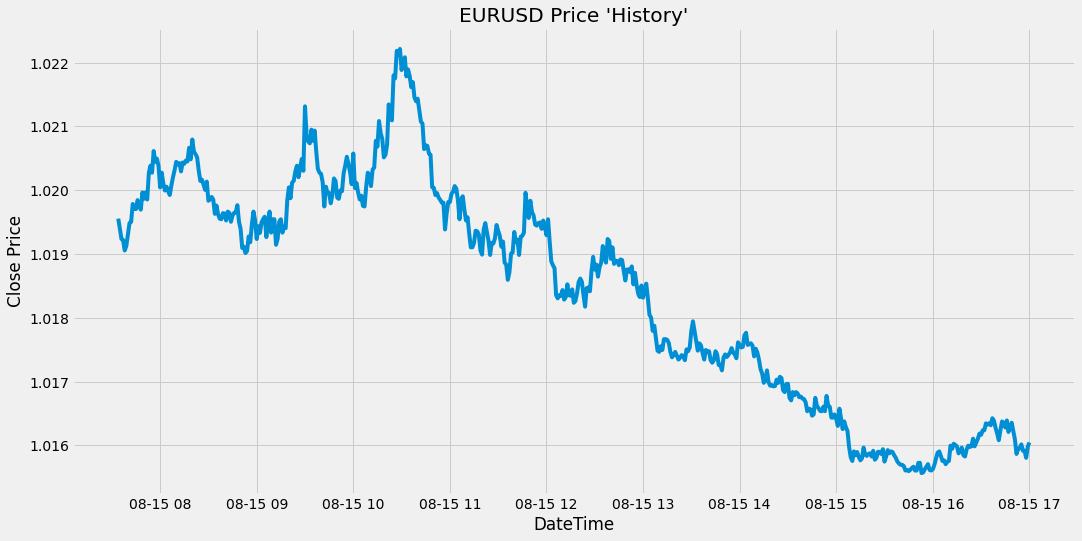

In [64]:
# Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title("EURUSD Price 'History'")
plt.plot(df['close'])
plt.xlabel('DateTime')
plt.ylabel('Close Price')
plt.show()

In [143]:
# Create a DataFrame with only close prices
data = df.filter(['close'])

# Converting to numpy array
dataset = data.values

# Calculate training data lenght 
training_data_len = math.ceil(len(dataset) * 0.85)

# Display the number of training samples
training_data_len

482

In [144]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# Display 
scaled_data

array([[0.6       ],
       [0.57593985],
       [0.5518797 ],
       [0.54962406],
       [0.52481203],
       [0.53533835],
       [0.56240602],
       [0.58947368],
       [0.5924812 ],
       [0.63458647],
       [0.62255639],
       [0.62255639],
       [0.64360902],
       [0.63007519],
       [0.62105263],
       [0.66165414],
       [0.64661654],
       [0.66165414],
       [0.64511278],
       [0.7075188 ],
       [0.72481203],
       [0.70827068],
       [0.7593985 ],
       [0.73383459],
       [0.74135338],
       [0.72481203],
       [0.67368421],
       [0.70827068],
       [0.68270677],
       [0.66616541],
       [0.67518797],
       [0.66466165],
       [0.6556391 ],
       [0.67819549],
       [0.69774436],
       [0.71428571],
       [0.73383459],
       [0.72781955],
       [0.73082707],
       [0.7112782 ],
       [0.73233083],
       [0.72932331],
       [0.73684211],
       [0.73458647],
       [0.76691729],
       [0.73984962],
       [0.78646617],
       [0.757

In [145]:
# Create the training dataset 
train_data = scaled_data[0:training_data_len, :]

# Split training data into x_train & y_train
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i - 60 : i, 0])
  y_train.append(train_data[i, 0])
  
  # Lets see how it looks
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.6       , 0.57593985, 0.5518797 , 0.54962406, 0.52481203,
       0.53533835, 0.56240602, 0.58947368, 0.5924812 , 0.63458647,
       0.62255639, 0.62255639, 0.64360902, 0.63007519, 0.62105263,
       0.66165414, 0.64661654, 0.66165414, 0.64511278, 0.7075188 ,
       0.72481203, 0.70827068, 0.7593985 , 0.73383459, 0.74135338,
       0.72481203, 0.67368421, 0.70827068, 0.68270677, 0.66616541,
       0.67518797, 0.66466165, 0.6556391 , 0.67819549, 0.69774436,
       0.71428571, 0.73383459, 0.72781955, 0.73082707, 0.7112782 ,
       0.73233083, 0.72932331, 0.73684211, 0.73458647, 0.76691729,
       0.73984962, 0.78646617, 0.75789474, 0.7518797 , 0.7443609 ,
       0.71278195, 0.6887218 , 0.69172932, 0.67969925, 0.66766917,
       0.68721805, 0.64210526, 0.64511278, 0.65112782, 0.64511278])]
[0.6112781954887225]

[array([0.6       , 0.57593985, 0.5518797 , 0.54962406, 0.52481203,
       0.53533835, 0.56240602, 0.58947368, 0.5924812 , 0.63458647,
       0.62255639, 0.62255639, 0.643

In [146]:
# Convert the training dataset to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data; because LSTM is expecting 3 Dims
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# print
x_train.shape

(422, 60, 1)

In [147]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [148]:
# Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')

##Fiting the model

In [204]:
# Train the model
model.fit(x_train, y_train, batch_size=60, epochs=500)

Epoch 1/500
8/8 [==============================] - 1s 114ms/step - loss: 7.1419e-04
Epoch 2/500
8/8 [==============================] - 1s 134ms/step - loss: 7.2030e-04
Epoch 3/500
8/8 [==============================] - 1s 94ms/step - loss: 7.6201e-04
Epoch 4/500
8/8 [==============================] - 0s 58ms/step - loss: 7.0160e-04
Epoch 5/500
8/8 [==============================] - 0s 60ms/step - loss: 6.9485e-04
Epoch 6/500
8/8 [==============================] - 0s 59ms/step - loss: 7.3856e-04
Epoch 7/500
8/8 [==============================] - 0s 59ms/step - loss: 7.2978e-04
Epoch 8/500
8/8 [==============================] - 1s 63ms/step - loss: 7.0646e-04
Epoch 9/500
8/8 [==============================] - 1s 62ms/step - loss: 6.9906e-04
Epoch 10/500
8/8 [==============================] - 0s 61ms/step - loss: 6.8215e-04
Epoch 11/500
8/8 [==============================] - 0s 59ms/step - loss: 7.9006e-04
Epoch 12/500
8/8 [==============================] - 0s 61ms/step - loss: 7.7760e-04

##Create a test dataset

Store the scaled values to `x_test` and the full dataset with non-scaled numbers into `y_test`

In [205]:
# Create a new array containing scaled values
test_data = scaled_data[training_data_len - 60:, :]

x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i - 60: i, 0])

# display
x_test

[array([0.18796992, 0.17894737, 0.18045113, 0.17593985, 0.17443609,
        0.16691729, 0.14586466, 0.1518797 , 0.15037594, 0.13533835,
        0.13834586, 0.17744361, 0.15864662, 0.15338346, 0.14661654,
        0.14586466, 0.15639098, 0.14586466, 0.18195489, 0.1593985 ,
        0.15639098, 0.13082707, 0.13082707, 0.13834586, 0.12781955,
        0.1112782 , 0.1518797 , 0.12932331, 0.1037594 , 0.12180451,
        0.10827068, 0.09924812, 0.06165414, 0.03759398, 0.02857143,
        0.05112782, 0.04210526, 0.04962406, 0.03834586, 0.03007519,
        0.03458647, 0.06015038, 0.04360902, 0.0406015 , 0.04511278,
        0.04661654, 0.03909774, 0.05263158, 0.03157895, 0.03609023,
        0.05037594, 0.04962406, 0.04511278, 0.05639098, 0.02706767,
        0.03909774, 0.05413534, 0.04661654, 0.05112782, 0.04962406]),
 array([0.17894737, 0.18045113, 0.17593985, 0.17443609, 0.16691729,
        0.14586466, 0.1518797 , 0.15037594, 0.13533835, 0.13834586,
        0.17744361, 0.15864662, 0.15338346, 0.

In [206]:
# Convert the test list into a numpy array
x_test = np.array(x_test)

# Reshape the test data because LSTM expect 3 Dims
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Display
x_test.shape

(85, 60, 1)

In [207]:
# Get the predicted values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(((predictions- y_test)**2)))

# Display
rmse 

8.440848826894459e-05

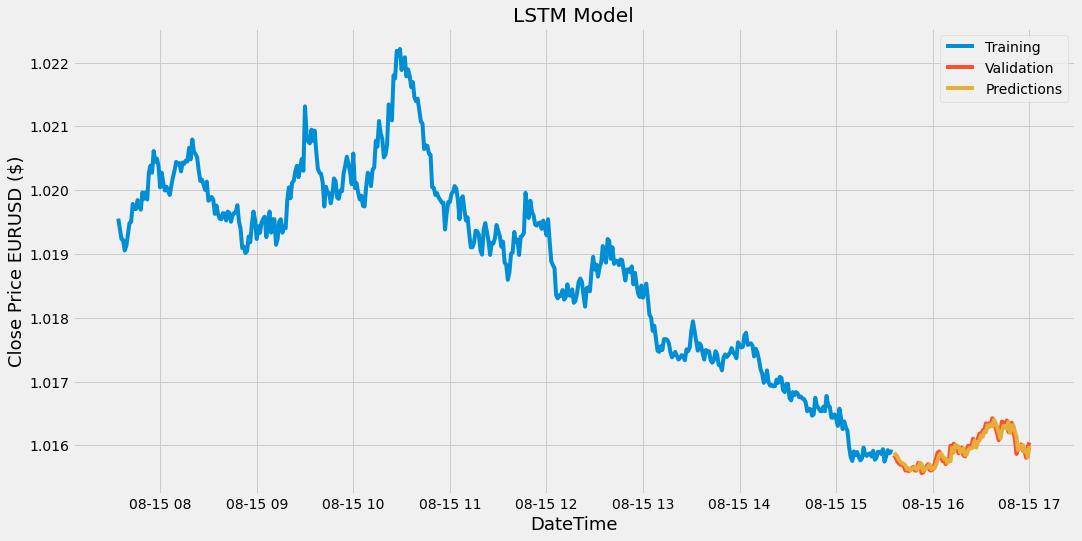

In [208]:
# Ploting the data
train = data[: training_data_len]
valid = data[training_data_len :]
valid['predictions'] = predictions

# Visualize data
plt.figure(figsize=(16,8))
plt.title('LSTM Model')
plt.xlabel('DateTime', fontsize=18)
plt.ylabel('Close Price EURUSD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'predictions']])
plt.legend(['Training', 'Validation', 'Predictions'], loc='upper right')
plt.show()

In [203]:
# Show the valid and predicted prices
valid

,close,predictions
date,,
2022-08-15 15:36:00,1.015845,1.015841
2022-08-15 15:37:00,1.015805,1.015806
2022-08-15 15:38:00,1.015745,1.015776
2022-08-15 15:39:00,1.015715,1.015723
2022-08-15 15:40:00,1.015695,1.015695
...,...,...
2022-08-15 16:56:00,1.015915,1.015952
2022-08-15 16:57:00,1.015915,1.015861
2022-08-15 16:58:00,1.015805,1.015877
